# Chebyshev補間の最大値最小値

Chebyshev補間によって与えられた関数の最大最小を以下のような手順で求める。

1. Chebyshev係数から[Chebyshev補間の微分](https://www.risk.tsukuba.ac.jp/~takitoshi/tutorial/Chebdiff.html)を計算する
1. 微分した[Chebyshev補間の零点を計算](https://www.risk.tsukuba.ac.jp/~takitoshi/tutorial/Chebroot.html)し、極大値・極小値を求める
1. 元のChebyshev補間の端点の値と極大値・極小値を比較し、最大・最小値を求める


### 1. Chebyshev補間を行い、Chebyshev係数を求める。

Chebyshev補間については、`Chebyshev_series`で作成した`Cheb`関数を使用することで、関数を適切な多項式の数では関する事ができる。

In [12]:
chebpts(10)

11-element Vector{Float64}:
 -1.0
 -0.9510565162951536
 -0.8090169943749475
 -0.5877852522924731
 -0.30901699437494745
  0.0
  0.30901699437494745
  0.5877852522924731
  0.8090169943749475
  0.9510565162951536
  1.0

In [11]:
include("FourierChebyshev.jl")
f(x) = sinpi(x)
a = cheb(f)

20-element Vector{Float64}:
  0.0
  0.5692306863595056
  0.0
 -0.6669166724059791
  0.0
  0.10428236873423688
  0.0
 -0.006840633536991628
  0.0
  0.0002500068849502345
  0.0
 -5.85024830876735e-6
  0.0
  9.534772756236639e-8
  0.0
 -1.14563837492903e-9
  0.0
  1.0574698107039368e-11
  0.0
 -7.735734567535396e-14

### 2. Chebyshev補間の微分を計算する。
極大値・極小値を計算する為にChebyshev補間の微分を計算する。`Chebyshev_differential`で作成した`Cheb_diff`関数を使用してChebyshev補間の微分の係数を計算する。

In [3]:
reshape([chebdiff(a);chebdiff(chebdiff(a))],20,2)

20×2 Matrix{Float64}:
 -0.955805      0.0
  0.0          -5.61808
 -3.05007       0.0
  0.0           6.5822
  0.951429      0.0
  0.0          -1.02923
 -0.091395      0.0
  0.0           0.0675143
  0.00437386    0.0
  0.0          -0.00246747
 -0.00012626    0.0
  0.0           5.77396e-5
  2.44503e-6    0.0
  0.0          -9.41046e-7
 -3.40126e-8    0.0
  0.0           1.13054e-8
  3.566e-10     0.0
  0.0          -1.05825e-10
 -2.93958e-12   0.0
  0.0           0.0

Chebyshev係数が区間で入力された場合には以下を使用する。

In [4]:
using IntervalArithmetic,LinearAlgebra

function chebdiff(ia::Vector{Interval{T}}; I=[-1,1])where T # Input is Two-sided (inverval)
    M = length(a)
    ib = zeros(Interval{T},M+1)
    for r = M-1:-1:1
        ib[r] = ib[r+2] + 2*r*ia[r+1]
    end
    ib[1] /= 2.0
    return ib[1:end-2]*(2/(interval(I[2])-I[1])) # Output is Two-sided (interval)
end

chebdiff (generic function with 2 methods)

### 3. 微分した関数の零点を計算することで極大・極小値を求める。

In [5]:
function verifyeig(A,lam,x,B = I)
    x = x./sqrt(x'*x)
    ysize = length(x)
    ix = map(Interval,x)
    DF(w) = [0 transpose(2*(x+w[2:end])) ; -B*(x+w[2:end]) A-(lam.+w[1])*B]
    zero =zeros(ysize+1)
    R = inv(mid.(DF(zero)))
    z = -R*[dot(x,x)-1;A*x-lam*B*x]
    # ϵ = 2*maximum(sup,abs.(z))
    r = abs.(mid.(z))
    u = 2*r .+ (sum(r)/length(r))
    # u = ϵ*ones(ysize+1)
    if isreal(lam) && isreal(x)
        lam = real(lam)
        # x = real(x)
        iw = interval.(-u,u)
        # id = ϵ*interval.(-1,1)
        # iy =  ϵ*interval.(-ones(ysize),ones(ysize))
    else
        iw = Complex(interval.(-u,u),interval.(-u,u))
        # id =Complex(interval(-ϵ,ϵ),interval(-ϵ,ϵ))
        # iy = Complex.(interval(-ϵ,ϵ)*ones(ysize),interval(-ϵ,ϵ)*ones(ysize))
    end    
    # iw = [id;iy]

    g(w) = z + (I-R*DF(w)) * w
    gw = g(iw)
    if all(gw .⊂ iw)
        while maximum(radius,gw) >= 5e-10
            gw = g(gw)       
        end
        return lam .+ gw[1] 
    else
        return NaN
    end
end

verifyeig (generic function with 2 methods)

In [6]:
function cheb_root(ia::Vector{Interval{T}}, I=[-1,1])where T
    I_lo = I[1]; I_up = I[2]
    a = mid.(ia)
    n = length(ia)
    du = [1; ones(n-3)*0.5]
    dl = ones(n-2)*0.5
    d  = zeros(n-1)
    C_1  = Tridiagonal(dl, d, du)
    iC_1 = map(Interval, C_1)
    C_2 = zeros(n-1,n-1)
    C_2[end,:] = a[1:end-1]/a[n]
    iC_2 = 0.5*map(Interval,C_2)
    C = iC_1-iC_2
    C_mid = mid.(C)
    lam, x = eigen(C_mid)
    ε = 100*eps()*(I_up-I_lo)*0.5 
    ind = findall((-1-ε .≤ real(lam) .≤ 1+ε) .& (imag(lam) .≈ 0))
    lam = real(lam[ind]) #
    x = real(x[:,ind])　#Approximate eigenvector
    
    ilam = zeros(Interval,length(lam))
    for i = 1:length(lam)
         ilam[i] = verifyeig(C,lam[i],x[:,i])
    end

    if I_lo==-1.0 && I_up==1.0
        return ilam
    else
        return (1.0 .- ilam).*I_lo/2 + (1.0 .+ ilam).*I_up/2
    end
    # return ilam
    # return (1.0 .- ilam).*I[1]/2 + (1.0 .+ ilam).*I[2]/2
end

cheb_root (generic function with 2 methods)

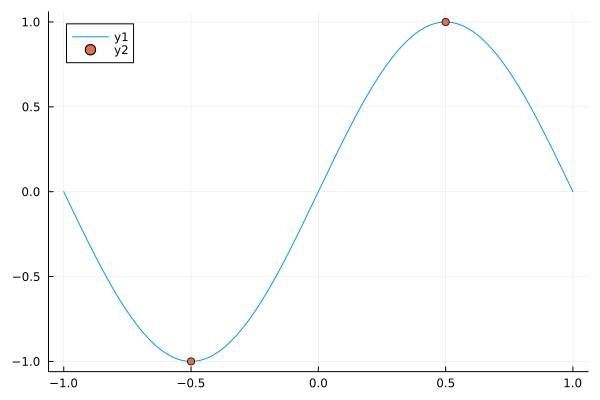

In [7]:
f(x) = sinpi(x)
a = cheb(f)
ia = map(Interval,a)
ib = chebdiff(ia)
ix = cheb_root(ib)
x = mid.(ix)
plot(f,-1,1)
scatter!(x,f.(x))

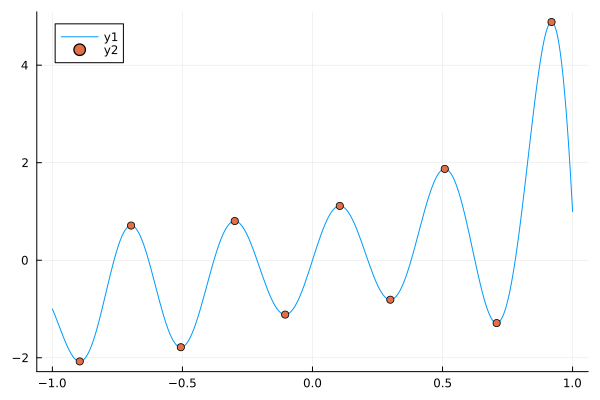

In [7]:
using SpecialFunctions
f(x) = exp(erf(x^2)+x^5)*sinpi(5x) + x
a = cheb(f)
ia = map(Interval,a)
ib = chebdiff(ia)
ix = cheb_root(ib)
x = mid.(ix)
plot(f,-1,1)
scatter!(x,f.(x))

### 4.端点の値を計算する。

### 5.端点の値と極大値・極小値を比較し最大値、最小値を求める。